In [1]:
import sys
sys.path.append('/Users/zhengj10/Python/Modules')

import h5py
import os
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import PatcherBot as pb
from glob import glob
import seaborn as sns
from read_roi import read_roi_file
from read_roi import read_roi_zip
import nd2reader
import tifffile as tff
from matplotlib.path import Path


#### Function for roi extraction and dFF calculation

In [2]:
def get_roi(roizip,ref):
    Fiji_rois = read_roi_zip(roizip) # '/Users/zhengj10/Desktop/RoiSet_pb_cell_edge.zip'
    
    rois = []
    for key in(Fiji_rois):
        x = Fiji_rois[key]['x']
        y = Fiji_rois[key]['y']
        roi = [x,y]
        rois.append(roi)
    
    rois_coordinates = []
    for roi in rois:
        roi_coordinates = np.array([roi[1],roi[0]]) # To match X,Y with image
        roi_coordinates = roi_coordinates.transpose()
        rois_coordinates.append(roi_coordinates)
    
    image_coordinates = []
    for r in range(ref.shape[0]):
        for c in range(ref.shape[1]):
            image_coordinates.append([r,c])

    p_roi = Path(rois_coordinates[0])
    ROI = p_roi.contains_points(image_coordinates)
    roi = ROI.reshape(ref.shape)
    
    p_fb = Path(rois_coordinates[1])
    ROI_fb = p_fb.contains_points(image_coordinates)
    fb = ROI_fb.reshape(ref.shape)
    return roi, fb


In [3]:
def get_dff(image,roi,fb,vstep=0,rig='bot'):

    
    if rig=='manual_Ahmed':
        f0 = np.sum(np.mean(image[200:300,:,:],axis=0)*roi)/np.sum(roi)
        fb = np.sum(np.mean(image[200:300,:,:],axis=0)*fb)/np.sum(fb)
        dff_all = []
        F = []
        for frame in range(image.shape[0]):
            f = np.sum((image[frame,:,:]*roi))/np.sum(roi)
            F.append(f)
            dff = (f-f0)/(f0-fb)
            dff_all.append(dff)
            
        if vstep<6:
            dff_peak = np.min(dff_all)
        else:
            dff_peak = np.max(dff_all)
#         dff_steady = np.mean(dff_all[800:850]) # for cell 5
        dff_steady = np.mean(dff_all[600:700]) # for cell 6
    
    elif rig=='bot':
        f0 = np.sum(np.mean(image[200:300,:,:],axis=0)*roi)/np.sum(roi)
        fb = np.sum(np.mean(image[200:300,:,:],axis=0)*fb)/np.sum(fb)
        dff_all = []
        F = []
        for frame in range(image.shape[0]):
            f = np.sum((image[frame,:,:]*roi))/np.sum(roi)
            F.append(f)
            dff = (f-f0)/(f0-fb)
            dff_all.append(dff)
        if vstep<2:
            dff_peak = np.mean(dff_all[600:610])
        else:
            dff_peak = np.mean(dff_all[480:490])
        dff_steady = np.mean(dff_all[1000:1100])
        
    elif rig=='manual_Jihong':
        f0 = np.sum(np.mean(image[1200:1300,:,:],axis=0)*roi)/np.sum(roi)
        fb = np.sum(np.mean(image[1200:1300,:,:],axis=0)*fb)/np.sum(fb)
        dff_all = []
        F = []
        for frame in range(image.shape[0]):
            f = np.sum((image[frame,:,:]*roi))/np.sum(roi)
            F.append(f)
            dff = (f-f0)/(f0-fb)
            dff_all.append(dff)
        dff_peak = np.mean(dff_all[2000+(vstep*2000+15):2000+(vstep*2000+25)])
        dff_steady = np.mean(dff_all[2000+(vstep*2000+850):2000+(vstep*2000+900)])
    
    return F, dff_all, dff_peak, dff_steady


## PatcherBot data

In [4]:
columns = ['Date','Plate','Well','Cell','Mutation','Transfected_date',
           'dFF_trace_body','dFF_peak_body','dFF_steady_body','dFF_trace_edge','dFF_peak_edge','dFF_steady_edge']

In [5]:
rawPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/200716'
# rawPath = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_raw'
# datePath = ['2020.02.24_000']
datePath = ['200716']
os.path.exists(rawPath)


True

In [6]:
data_all = {}
for param in(columns):
    data_all[param] = []
for date in datePath:
    platePath = pb.getPathInfo(os.path.join(rawPath, date))
    for plate in platePath:
        idxFile = os.path.join(rawPath, date, plate, '.index')
        meta = yaml.load(open(idxFile), Loader=yaml.FullLoader)
        mutation = meta['.']['mutation_1']
        note = meta['.']['notes'][0:6]
        
        cellPath = pb.getPathInfo(os.path.join(rawPath, date, plate))
        c = 0

        for cell in(cellPath):
#         for cell in (['patch_attempt_0013_000']):
            print(cell)
            data_all['Date'].append(date)
            data_all['Plate'].append(plate)
            data_all['Cell'].append(cell)
            data_all['Mutation'].append(mutation)
            data_all['Transfected_date'].append(note)
            data_all['Well'].append('well_1')
            dFF_trace_body = []
            dFF_peak_body = []
            dFF_steady_body = []
            dFF_trace_edge = []
            dFF_peak_edge = []
            dFF_steady_edge = []

            
            for trial in range(9):
                imgFile = os.path.join(rawPath,date,plate,cell,'camera_clamp1_000',str(trial).zfill(3),'Camera','frames.ma')
                data = h5py.File(imgFile,'r')
                imgData = data['data'][()]
                
                if trial == 0:
                    imsave(rawPath+'/cell_%d.tif' %c, imgData.astype('float32'))
                    ref = np.mean(imgData,axis=0)
                    roizip_cell_body = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_'+str(trial)+'_cell_body.zip'
                    roizip_cell_edge = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_'+str(trial)+'_cell_edge.zip'
                    
                roi_body, fb_body = get_roi(roizip_cell_body,ref)
                roi_edge, fb_edge = get_roi(roizip_cell_edge,ref)

                F,dff_all_body,dff_peak_body,dff_steady_body = get_dff(imgData,roi_body,fb_body,vstep=trial,rig='bot')
                F,dff_all_edge,dff_peak_edge,dff_steady_edge = get_dff(imgData,roi_edge,fb_edge,vstep=trial,rig='bot')
                dFF_trace_body.append(dff_all_body)
                dFF_peak_body.append(dff_peak_body)
                dFF_steady_body.append(dff_steady_body)
                dFF_trace_edge.append(dff_all_edge)
                dFF_peak_edge.append(dff_peak_edge)
                dFF_steady_edge.append(dff_steady_edge)
            c+=1
            data_all['dFF_trace_body'].append(dFF_trace_body)
            data_all['dFF_peak_body'].append(dFF_peak_body)
            data_all['dFF_steady_body'].append(dFF_steady_body)
            data_all['dFF_trace_edge'].append(dFF_trace_edge)
            data_all['dFF_peak_edge'].append(dFF_peak_edge)
            data_all['dFF_steady_edge'].append(dFF_steady_edge)


NameError: name 'columns' is not defined

In [7]:
df = pd.DataFrame(data_all)
df
# for k in data_all.keys():
#     print(k,len(data_all[k]))


,Date,Plate,Well,Cell,Mutation,Transfected_date,dFF_trace_body,dFF_peak_body,dFF_steady_body,dFF_trace_edge,dFF_peak_edge,dFF_steady_edge
0,2020.02.24_000,plate_000,well_1,patch_attempt_0001_000,421.1,200218,"[[0.0024094020528893307, 0.0026360147838800654...","[0.021275143145355394, 0.007966647764896926, -...","[0.020645922836886862, 0.005811035609922231, -...","[[0.002434574947544066, -0.0007878568346314625...","[0.024779290101908723, 0.008698790001924236, -...","[0.025783791176543235, 0.00907709526253064, -0..."
1,2020.02.24_000,plate_000,well_1,patch_attempt_0004_000,421.1,200218,"[[-0.0023841381679538514, 0.003062306457995849...","[0.023839692629797016, 0.010393382736839731, -...","[0.02107246612601944, 0.007698864390654358, -0...","[[0.00519694398370878, 0.00028114430267412084,...","[0.02385162907700995, 0.010629903940606067, -0...","[0.022627186480240997, 0.009248544855807816, -..."
2,2020.02.24_000,plate_000,well_1,patch_attempt_0008_000,421.1,200218,"[[-0.01843520060496405, -0.004532085337067431,...","[0.03720037728535841, 0.014258637162940253, -0...","[0.03716590020141629, 0.013684163691356041, -0...","[[-0.019469445086328665, -0.003689047853891586...","[0.04178530350533132, 0.0148358004246429, -0.0...","[0.0430184406761046, 0.015892759080821325, -0...."
3,2020.02.24_000,plate_000,well_1,patch_attempt_0010_000,421.1,200218,"[[0.03355433840189894, -0.0013791296154740725,...","[0.04467870099187375, 0.01383601521379264, -0....","[0.044068275756829804, 0.0128005964323884, -0....","[[0.06926913093766045, 0.01740495349698299, -0...","[0.048431174948149504, 0.015721116337345263, 0...","[0.04128400828945199, 0.010777656150282946, -0..."
4,2020.02.24_000,plate_000,well_1,patch_attempt_0012_000,421.1,200218,"[[-0.006036833526270706, -0.00658476805318566,...","[0.017256003708894827, 0.004559560847186505, -...","[0.014708318902791388, 0.0037377490322103623, ...","[[-0.009478889010671, -0.005443411191559445, 0...","[0.02124412175080512, 0.00788582477208141, -0....","[0.01815409873502842, 0.004904248455056071, -0..."
5,2020.02.24_000,plate_000,well_1,patch_attempt_0013_000,421.1,200218,"[[-0.0011843632929159035, -0.00423995837890897...","[0.031345831338176915, 0.008623254480397621, -...","[0.0280961053308491, 0.009847477407875475, -0....","[[0.026140237243512124, 0.005183806094054982, ...","[0.015217113309063173, 0.010610017942520663, -...","[0.02307328017687817, 0.008126022026394224, -0..."


In [8]:
# df.to_pickle('/Users/zhengj10/Desktop/PB_vs_Ahmed/Summary/PB_summary.pkl')
# df.to_excel('/Users/zhengj10/Desktop/PB_vs_Ahmed/Summary/PB_summary.xlsx')

### Plot individual cells (PatcherBot)

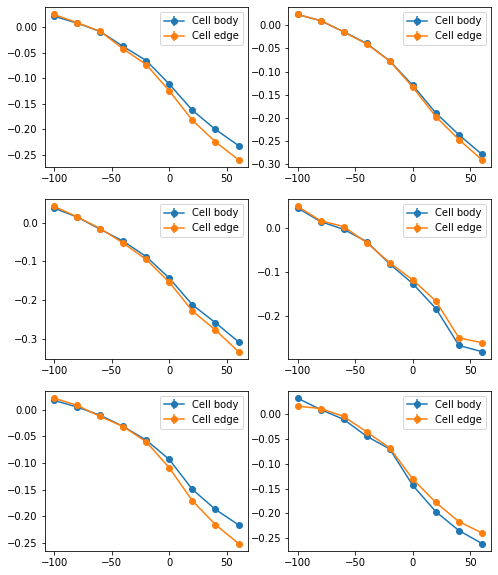

In [9]:
sns.reset_orig()

fig = plt.figure(figsize=[8,10])
for i,r in df.iterrows():
    peak_body = df.loc[i,'dFF_peak_body']
    peak_edge = df.loc[i,'dFF_peak_edge']
#     print(peak_body)

    x = np.linspace(-100,60,9)

    ax = plt.subplot(3,2,i+1)
    ax.errorbar(x, peak_body, yerr = 0, fmt = 'o-',label='Cell body')
    ax.errorbar(x, peak_edge, yerr = 0, fmt = 'o-',label='Cell edge')
    ax.legend()
plt.show()


### Group plot (PatcherBot)

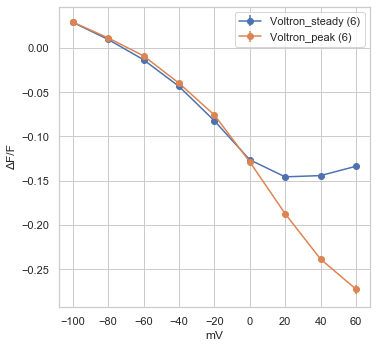

In [10]:
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[5.4,5])
peak_body_mean = np.nanmean(df['dFF_peak_body'].tolist(), axis=0)
peak_body_sem = np.nanstd(df['dFF_peak_body'].tolist(), axis=0)/(len(df))
peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

steady_edge_mean = np.nanmean(df['dFF_steady_edge'].tolist(), axis=0)
steady_edge_sem = np.nanstd(df['dFF_steady_edge'].tolist(), axis=0)/(len(df))
peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

x = np.linspace(-100,60,9)
ax = plt.subplot(111)

ax.errorbar(x, steady_edge_mean, yerr = steady_edge_sem, fmt = 'o-',label='Voltron_steady (6)')
ax.errorbar(x, peak_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Voltron_peak (6)')

# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell body')
# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell edge')

ax.legend()
ax.set_xticks(x)

ax.set_xlabel('mV',size=12)
ax.set_ylabel('\u0394F/F',size=12)
plt.tight_layout()

# fig.savefig('/Users/zhengj10/Desktop/pb_group_steady_vs_peak.png',dpi=1200)
plt.show()


### Individual dFF trace (PatcherBot)

In [7]:
plt.figure(figsize=[10,10])
imgPath='/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/200716/200716/patch_attempt_0000_002'
for i in range(9):
    imgFile = os.path.join(imgPath,'camera_clamp1_000',str(i).zfill(3),'Camera','frames.ma')
    data = h5py.File(imgFile,'r')
    imgData = data['data'][()]
    ref = np.mean(imgData,axis=0)
    roizip_cell_edge = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_0_cell_edge.zip'             
    roi_edge,fb_edge = get_roi(roizip_cell_edge,ref)
    F, dff_all,dff_peak,dff_steady = get_dff(imgData,roi_edge,fb_edge,vstep=i,rig='bot')
    ax = plt.subplot(3,3,i+1)
    x_p = np.argmin(np.abs(dff_all-dff_peak))
    x_s = np.argmin(np.abs(dff_all-dff_steady))
#     ax.scatter(x_p,dff_peak,color='m',s=500)
#     ax.scatter(x_s,dff_steady,color='y',s=500)
#     ax.plot(F)
    ax.plot(dff_all)
#     ax.set_ylim([1700,1725])
    ax.set_ylim([-0.31,0.12])
    if i in [6,7,8]:
        ax.set_xlabel('ms',size=12)
    if i in [0,3,6]:
        ax.set_ylabel('\u0394F/F',size=12)
#     print(ax.get_ylim())
plt.tight_layout()

# plt.savefig('/Users/zhengj10/Desktop/individual_dFF_pb_cell_0013_cell_edge.png',dpi=1200)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_0_cell_edge.zip'

<Figure size 720x720 with 0 Axes>

## PatcherBot data (voltage error corrected)

In [12]:
columns = ['Date','Plate','Well','Cell','Mutation','Transfected_date',
           'dFF_trace_body','dFF_peak_body','dFF_steady_body',
           'dFF_trace_edge','dFF_peak_edge','dFF_steady_edge',
           'x_corrected']

In [13]:
rawPath = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_raw'
datePath = ['2020.02.24_000']
os.path.exists(rawPath)

True

In [14]:
data_all = {}
for param in(columns):
    data_all[param] = []
for date in datePath:
    platePath = pb.getPathInfo(os.path.join(rawPath, date))
    for plate in platePath:
        idxFile = os.path.join(rawPath, date, plate, '.index')
        meta = yaml.load(open(idxFile), Loader=yaml.FullLoader)
        mutation = meta['.']['mutation_1']
        note = meta['.']['notes'][0:6]
        
        cellPath = pb.getPathInfo(os.path.join(rawPath, date, plate))

        for cell in(cellPath):
#         for cell in (['patch_attempt_0013_000']):
            print(cell)
            data_all['Date'].append(date)
            data_all['Plate'].append(plate)
            data_all['Cell'].append(cell)
            data_all['Mutation'].append(mutation)
            data_all['Transfected_date'].append(note)
            data_all['Well'].append('well_1')
            dFF_trace_body = []
            dFF_peak_body = []
            dFF_steady_body = []
            dFF_trace_edge = []
            dFF_peak_edge = []
            dFF_steady_edge = []
            Actual_voltage = []
            
            for trial in range(9):
                imgFile = os.path.join(rawPath,date,plate,cell,'camera_clamp1_000',str(trial).zfill(3),'Camera','frames.ma')
                data = h5py.File(imgFile,'r')
                imgData = data['data'][()]
                
                if trial == 0:
                    ref = np.mean(imgData,axis=0)
                    roizip_cell_body = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_'+str(trial)+'_cell_body.zip'
                    roizip_cell_edge = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/PB_processed/RoiSet_cell_'+str(trial)+'_cell_edge.zip'
                    
                roi_body, fb_body = get_roi(roizip_cell_body,ref)
                roi_edge, fb_edge = get_roi(roizip_cell_edge,ref)

                F,dff_all_body, dff_peak_body, dff_steady_body = get_dff(imgData,roi_body,fb_body,vstep=trial,rig='bot')
                F,dff_all_edge, dff_peak_edge, dff_steady_edge = get_dff(imgData,roi_edge,fb_edge,vstep=trial,rig='bot')
                actual_voltage = pb.get_actual_voltage(os.path.join(rawPath,date,plate,cell,'camera_clamp1_000',str(trial).zfill(3),'Clamp1.ma'), trial)
                dFF_trace_body.append(dff_all_body)
                dFF_peak_body.append(dff_peak_body)
                dFF_steady_body.append(dff_steady_body)
                dFF_trace_edge.append(dff_all_edge)
                dFF_peak_edge.append(dff_peak_edge)
                dFF_steady_edge.append(dff_steady_edge)
                Actual_voltage.append(actual_voltage)

            data_all['dFF_trace_body'].append(dFF_trace_body)
            data_all['dFF_peak_body'].append(dFF_peak_body)
            data_all['dFF_steady_body'].append(dFF_steady_body)
            data_all['dFF_trace_edge'].append(dFF_trace_edge)
            data_all['dFF_peak_edge'].append(dFF_peak_edge)
            data_all['dFF_steady_edge'].append(dFF_steady_edge)
            data_all['x_corrected'].append(Actual_voltage)

patch_attempt_0001_000
patch_attempt_0004_000
patch_attempt_0008_000
patch_attempt_0010_000
patch_attempt_0012_000
patch_attempt_0013_000


In [15]:
df = pd.DataFrame(data_all)
df
# for k in data_all.keys():
#     print(k,len(data_all[k]))

,Date,Plate,Well,Cell,Mutation,Transfected_date,dFF_trace_body,dFF_peak_body,dFF_steady_body,dFF_trace_edge,dFF_peak_edge,dFF_steady_edge,x_corrected
0,2020.02.24_000,plate_000,well_1,patch_attempt_0001_000,421.1,200218,"[[0.0024094020528893307, 0.0026360147838800654...","[0.021275143145355394, 0.007966647764896926, -...","[0.020645922836886862, 0.005811035609922231, -...","[[0.002434574947544066, -0.0007878568346314625...","[0.024779290101908723, 0.008698790001924236, -...","[0.025783791176543235, 0.00907709526253064, -0...","[-98.68608739556954, -79.71161714336698, -60.2..."
1,2020.02.24_000,plate_000,well_1,patch_attempt_0004_000,421.1,200218,"[[-0.0023841381679538514, 0.003062306457995849...","[0.023839692629797016, 0.010393382736839731, -...","[0.02107246612601944, 0.007698864390654358, -0...","[[0.00519694398370878, 0.00028114430267412084,...","[0.02385162907700995, 0.010629903940606067, -0...","[0.022627186480240997, 0.009248544855807816, -...","[-98.8474801856097, -79.68244648110645, -60.20..."
2,2020.02.24_000,plate_000,well_1,patch_attempt_0008_000,421.1,200218,"[[-0.01843520060496405, -0.004532085337067431,...","[0.03720037728535841, 0.014258637162940253, -0...","[0.03716590020141629, 0.013684163691356041, -0...","[[-0.019469445086328665, -0.003689047853891586...","[0.04178530350533132, 0.0148358004246429, -0.0...","[0.0430184406761046, 0.015892759080821325, -0....","[-99.23108364941945, -79.46586477896979, -60.2..."
3,2020.02.24_000,plate_000,well_1,patch_attempt_0010_000,421.1,200218,"[[0.03355433840189894, -0.0013791296154740725,...","[0.04467870099187375, 0.01383601521379264, -0....","[0.044068275756829804, 0.0128005964323884, -0....","[[0.06926913093766045, 0.01740495349698299, -0...","[0.048431174948149504, 0.015721116337345263, 0...","[0.04128400828945199, 0.010777656150282946, -0...","[-97.88017150394872, -79.58029543600402, -60.4..."
4,2020.02.24_000,plate_000,well_1,patch_attempt_0012_000,421.1,200218,"[[-0.006036833526270706, -0.00658476805318566,...","[0.017256003708894827, 0.004559560847186505, -...","[0.014708318902791388, 0.0037377490322103623, ...","[[-0.009478889010671, -0.005443411191559445, 0...","[0.02124412175080512, 0.00788582477208141, -0....","[0.01815409873502842, 0.004904248455056071, -0...","[-99.23486342673225, -79.56973766924688, -60.1..."
5,2020.02.24_000,plate_000,well_1,patch_attempt_0013_000,421.1,200218,"[[-0.0011843632929159035, -0.00423995837890897...","[0.031345831338176915, 0.008623254480397621, -...","[0.0280961053308491, 0.009847477407875475, -0....","[[0.026140237243512124, 0.005183806094054982, ...","[0.015217113309063173, 0.010610017942520663, -...","[0.02307328017687817, 0.008126022026394224, -0...","[-99.29823177430063, -79.75209072746716, -61.2..."


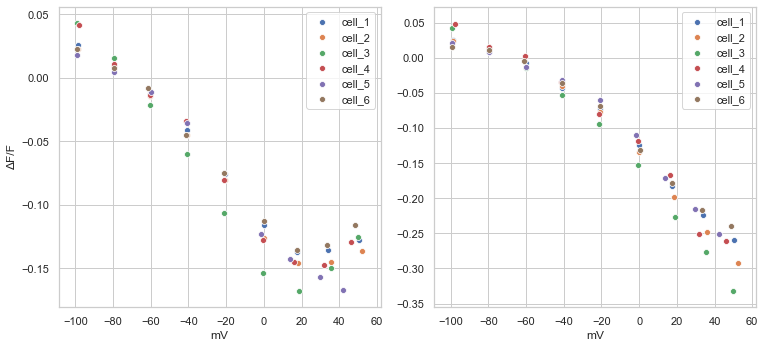

In [16]:
sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[10.8,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

for i,r in df.iterrows():
    sns.scatterplot(df['x_corrected'][i],df['dFF_steady_edge'][i],
                label='cell_%d' %(i+1),ax=ax1)

    sns.scatterplot(df['x_corrected'][i],df['dFF_peak_edge'][i],
                    label='cell_%d' %(i+1),ax=ax2)

x = np.linspace(-100,60,9)
ax1.set_ylabel('\u0394F/F',size=12)
ax1.set_xlabel('mV',size=12)
ax1.set_xticks(x)
ax2.set_xlabel('mV',size=12)
ax2.set_xticks(x)
plt.tight_layout()

# fig.savefig('/Users/zhengj10/Desktop/pb_individual_cell_voltage_corrected_peak_edge.png')
plt.show()


## Same figure plot of Ahmed's and PB data

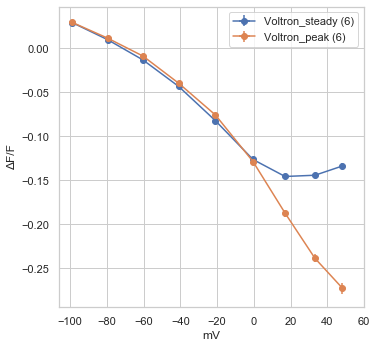

In [17]:
plt.figure(figsize=[5.4,5])
ax = plt.subplot(111)

### Comment out the following code to plot PB data only (Voltage error corrected)

# x = np.array([50,30,10,-10,-30,-50,-90,-110])
# # x = np.linspace(-110,50,8)
# ax.errorbar(x,y=dff_p_edge,yerr=0,fmt='-o',label='Ahmed_peak (1)')
# ax.errorbar(x,y=dff_s_edge,yerr=0,fmt='-o',label='Ahmed_steady (1)')
# plt.setp(ax, xticks=x)
# # plt.legend()
# # plt.show()


steady_edge_mean = np.nanmean(df['dFF_steady_edge'].tolist(), axis=0)
x = np.nanmean(df['x_corrected'].tolist(), axis=0)
steady_edge_err = np.nanstd(df['dFF_steady_edge'].tolist(), axis=0)/(len(df)-1)
x_err = np.nanstd(df['x_corrected'].tolist(), axis=0)/(len(df)-1)
ax.errorbar(x, steady_edge_mean, xerr = x_err, yerr = steady_edge_err, fmt = 'o-',label='Voltron_steady (6)')

peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
x = np.nanmean(df['x_corrected'].tolist(), axis=0)
peak_edge_err = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df)-1)
x_err = np.nanstd(df['x_corrected'].tolist(), axis=0)/(len(df)-1)
ax.errorbar(x, peak_edge_mean, xerr = x_err, yerr = peak_edge_err, fmt = 'o-',label='Voltron_peak (6)')



ax.legend()

x = np.linspace(-100,60,9)
ax.set_xticks(x)
ax.set_xlabel('mV',size=12)
ax.set_ylabel('\u0394F/F',size=12)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/pb&Ahmed_group_voltage_corrected.png',dpi=1200)

plt.show()


## Ahmed manual data

In [18]:
imgPath = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5'
imgFiles = glob(imgPath + '/*.nd2')
imgFiles = sorted(imgFiles)
imgFiles


['/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0001.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0002.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0003.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0004.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0005.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0006.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0007.nd2',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_raw/cell_5/cell5_V525_0008.nd2']

In [19]:
nd2 = nd2reader.Nd2(imgFiles[0])
image = np.array(nd2[:])
image.shape


(1200, 128, 512)

In [20]:
ref = np.mean(image,axis=0)
ref.shape

(128, 512)

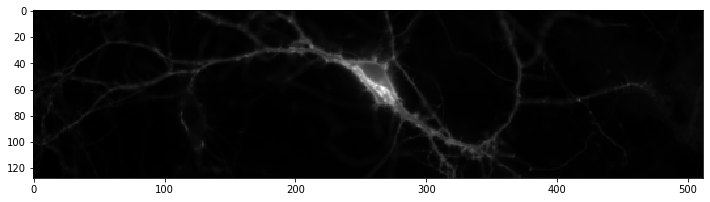

In [21]:
fig = plt.figure(figsize=[12,5])
sns.reset_orig()
plt.imshow(ref,cmap='gray')
plt.show()

In [22]:
# imsave('/Users/zhengj10/Desktop/cell6_ref.tif',ref.astype('float32'))
# imsave('/Users/zhengj10/Desktop/cell6.tif',image.astype('float32'))

In [23]:
roizip = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Ahmed_manual_processed/RoiSet_cell5_cell_edge.zip'
Fiji_rois = read_roi_zip(roizip)

In [24]:
rois = []
for key in(Fiji_rois):
    print(key)
    x = Fiji_rois[key]['x']
    y = Fiji_rois[key]['y']
    roi = [x,y]
    rois.append(roi)

0054-0259
0065-0217


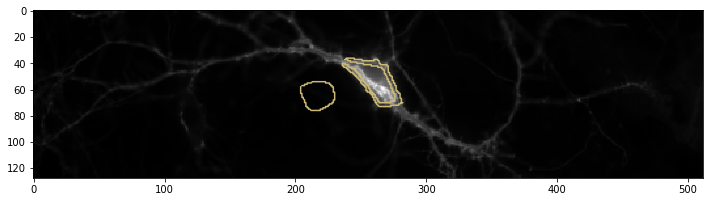

In [25]:
plt.figure(figsize=[12,12])
plt.imshow(ref,cmap='gray')
for roi in rois:
    plt.plot(roi[0],roi[1],color='y')
# plt.savefig('/Users/zhengj10/Desktop/ROI_pb_cell_edge.png')
plt.show()


In [26]:
rois_coordinates = []
for roi in rois:
    roi_coordinates = np.array([roi[1],roi[0]]) # To match X,Y with image
    roi_coordinates = roi_coordinates.transpose()
    print(roi_coordinates.shape)
    rois_coordinates.append(roi_coordinates)


(300, 2)
(92, 2)


In [27]:
image_coordinates = []
for r in range(ref.shape[0]):
    for c in range(ref.shape[1]):
        image_coordinates.append([r,c])

p_roi = Path(rois_coordinates[0])
ROI = p_roi.contains_points(image_coordinates)
roi = ROI.reshape(ref.shape)


p_fb = Path(rois_coordinates[1])
ROI_fb = p_fb.contains_points(image_coordinates)
fb = ROI_fb.reshape(ref.shape)

In [28]:
np.mean(roi)


0.00640869140625

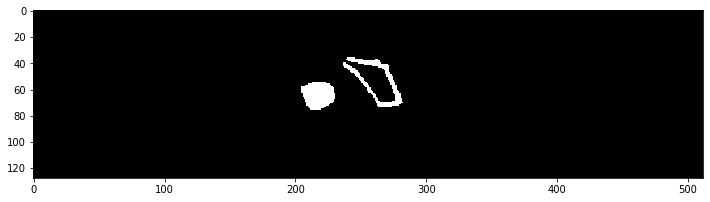

In [29]:
plt.figure(figsize=[12,12])
f_all = roi+fb
plt.imshow(f_all,cmap='gray')
# plt.imshow(roi,cmap='gray')
plt.show()


#### Individual dFF trace Ahmed data

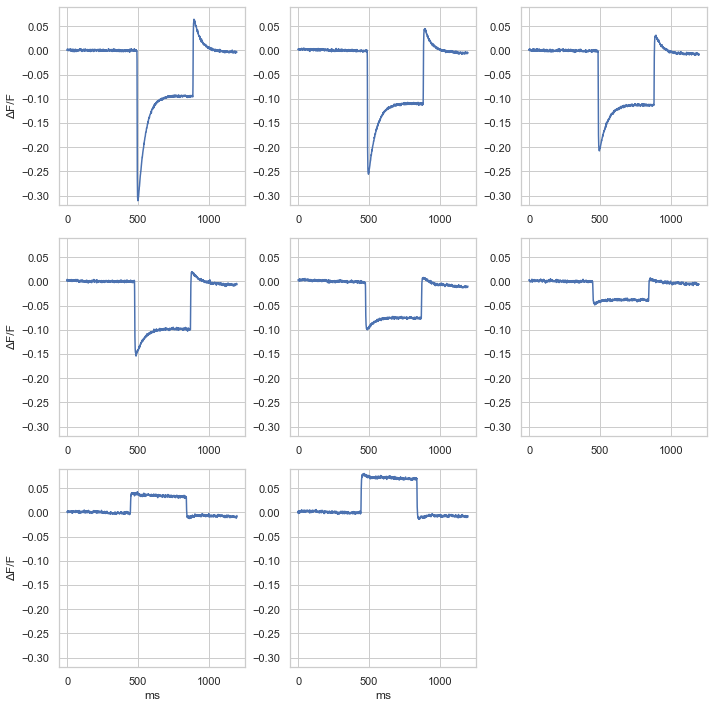

In [37]:
plt.figure(figsize=[10,10])
sns.set()
sns.set_style(style='whitegrid')
for i in range(len(imgFiles)):
    nd2 = nd2reader.Nd2(imgFiles[i])
    image = np.array(nd2[:])
    F, dff_all, dff_peak, dff_steady = get_dff(image,roi,fb,vstep=i,rig='manual_Ahmed')
    ax = plt.subplot(3,3,i+1)
    x_p = np.argmin(np.abs(dff_all-dff_peak))
    x_s = np.argmin(np.abs(dff_all-dff_steady))
#     ax.scatter(x_p,dff_peak,color='m',s=100)
#     ax.scatter(x_s,dff_steady,color='y',s=100)
#     ax.set_ylim([5100,7100])
    ax.set_ylim([-0.32,0.09])

    if i in [6,7,8]:
        ax.set_xlabel('ms',size=12)
    if i in [0,3,6]:
        ax.set_ylabel('\u0394F/F',size=12)

    ax.plot(dff_all)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/Ahmed_individual_dFF_cell5_cell_edge.png',dpi=1200)
plt.show()


In [31]:
dff_p = []
dff_s = []
for i in range(len(imgFiles)):
    nd2 = nd2reader.Nd2(imgFiles[i])
    image = np.array(nd2[:])
    print(image.shape)

    F, dff_all, dff_peak, dff_steady = get_dff(image,roi,fb,vstep=i,rig='manual_Ahmed')
    dff_p.append(dff_peak)
    dff_s.append(dff_steady)
    

(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)
(1200, 128, 512)


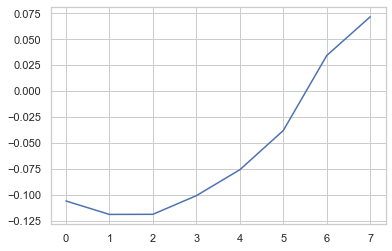

In [32]:
plt.plot(dff_s)
plt.show()


In [33]:
roi_sel = 'edge'
# roi_sel = 'body'

In [34]:
if roi_sel == 'edge':
    dff_p_edge = dff_p
    dff_s_edge = dff_s

elif roi_sel == 'body':
    dff_p_body = dff_p
    dff_s_body = dff_s


In [35]:
dff_p_edge

[-0.31052747164404004,
 -0.25585913183472014,
 -0.2076235413251862,
 -0.15433796107388495,
 -0.10004396090759833,
 -0.04873549631728963,
 0.04260245049828837,
 0.08019624999214352]

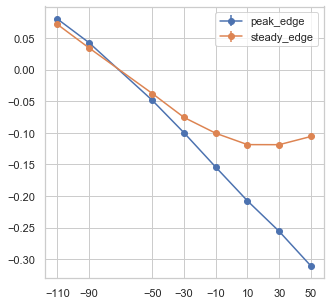

In [36]:
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid')

fig = plt.figure(figsize=[5,5])
ax = plt.subplot(111)
x = np.array([50,30,10,-10,-30,-50,-90,-110])
# x = np.linspace(-110,50,8)
ax.errorbar(x,y=dff_p_edge,yerr=0,fmt='-o',label='peak_edge')
ax.errorbar(x,y=dff_s_edge,yerr=0,fmt='-o',label='steady_edge')
plt.setp(ax, xticks=x)
plt.legend()
plt.show()
# fig.savefig('/Users/zhengj10/Desktop/pb_cell_edge_vs._cell_body.png')


## Jihong manual data

In [38]:
imgPath = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw'
imgFiles = glob(imgPath + '/*.tif')
imgFiles = sorted(imgFiles)
imgFiles


['/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_1.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_2.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_3.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_4.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_5.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_6.tif',
 '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_7.tif']

In [39]:
image = tff.TiffFile(imgFiles[3])
image = image.asarray()
image.shape

(25000, 32, 32)

In [40]:
ref = np.mean(image,axis=0)
ref.shape

(32, 32)

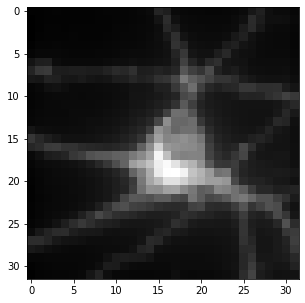

In [41]:
fig = plt.figure(figsize=[12,5])
sns.reset_orig()
plt.imshow(ref,cmap='gray')
plt.show()

In [42]:
# imsave('/Users/zhengj10/Desktop/PB_vs_Ahmed/Jihong_manual_processed/cell4_ref.tif',ref.astype('float32'))


In [43]:
roizip = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_processed/RoiSet_cell4_cell_edge.zip'
Fiji_rois = read_roi_zip(roizip)


In [44]:
rois = []
for key in(Fiji_rois):
    print(key)
    x = Fiji_rois[key]['x']
    y = Fiji_rois[key]['y']
    roi = [x,y]
    rois.append(roi)


0016-0019
0003-0007


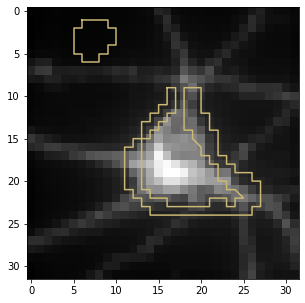

In [45]:
sns.reset_orig()
plt.figure(figsize=[5,5])
plt.imshow(ref,cmap='gray')
for roi in rois:
    plt.plot(roi[0],roi[1],color='y')
# plt.savefig('/Users/zhengj10/Desktop/ROI_manual_cell_edge.png')
plt.show()


In [46]:
rois_coordinates = []
for roi in rois:
    roi_coordinates = np.array([roi[1],roi[0]]) # To match X,Y with image
    roi_coordinates = roi_coordinates.transpose()
    print(roi_coordinates.shape)
    rois_coordinates.append(roi_coordinates)

(113, 2)
(21, 2)


In [47]:
image_coordinates = []
for r in range(ref.shape[0]):
    for c in range(ref.shape[1]):
        image_coordinates.append([r,c])

p_roi = Path(rois_coordinates[0])
ROI = p_roi.contains_points(image_coordinates)
roi = ROI.reshape(ref.shape)


p_fb = Path(rois_coordinates[1])
ROI_fb = p_fb.contains_points(image_coordinates)
fb = ROI_fb.reshape(ref.shape)


In [48]:
np.mean(roi)


0.099609375

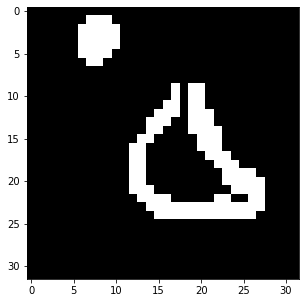

In [49]:
plt.figure(figsize=[5,5])
f_all = roi+fb
plt.imshow(f_all,cmap='gray')
# plt.imshow(roi,cmap='gray')
plt.show()

In [50]:
image.shape

(25000, 32, 32)

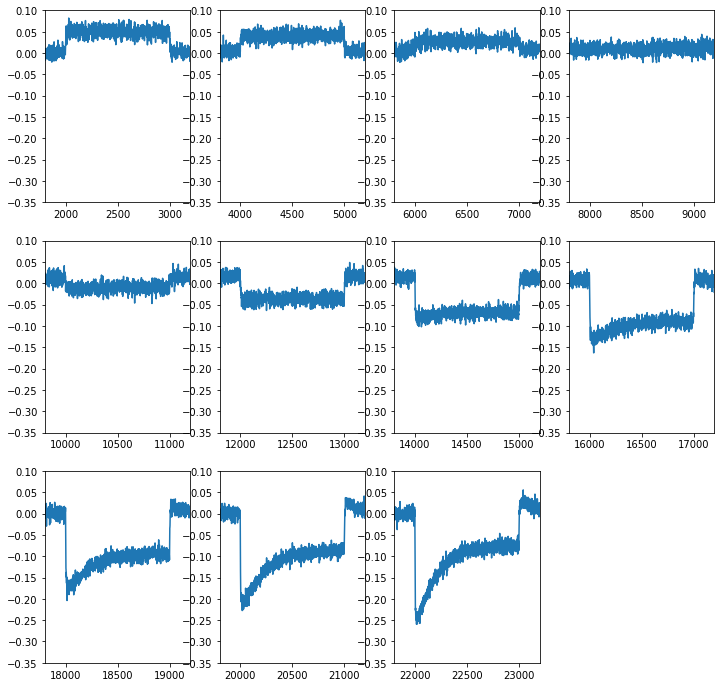

In [51]:
plt.figure(figsize=[12,12])
dff_p = []
dff_s = []
for i in range(11):
    F,dff_all, dff_peak, dff_steady = get_dff(image,roi,fb,vstep=i,rig='manual_Jihong')
    ax = plt.subplot(3,4,i+1)
    dff_p.append(dff_peak)
    dff_s.append(dff_steady)
#     x_p = np.argmin(np.abs(dff_all-dff_peak))
#     x_s = np.argmin(np.abs(dff_all-dff_steady))
#     ax.scatter(x_p,dff_peak,color='m',s=100)
#     ax.scatter(x_s,dff_steady,color='y',s=100)
    ax.set_ylim([-0.35,0.1])
    ax.set_xlim([1800+i*2000,3200+i*2000])
#     ax.set_xlim([22000,22050])
    ax.plot(dff_all)
# plt.savefig('/Users/zhengj10/Desktop/individual_dFF_cell6_cell_edge.png')
plt.show()


In [52]:
roi.shape

(32, 32)

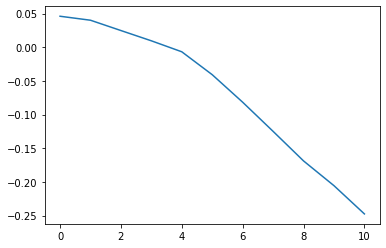

In [53]:
plt.plot(dff_p)
plt.show()


In [54]:
columns = ['Date','Dish','Cell','Mutation','Transfected_date',
           'dFF_trace_body','dFF_peak_body','dFF_steady_body','dFF_trace_edge','dFF_peak_edge','dFF_steady_edge']


In [55]:
rawPath = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw'


In [56]:
# i = 1
# for cell in imgFiles:
#     image = tff.TiffFile(cell)
#     image = image.asarray()
#     ref = np.mean(image,axis=0)
#     imsave('/Users/zhengj10/Desktop/PB_vs_Ahmed/Jihong_manual_processed/cell'+str(i)+'_ref.tif',ref.astype('float32'))
#     i+=1
    

In [57]:
imgFiles[3]

'/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_raw/cell_4.tif'

In [61]:
data_all = {}
for param in(columns):
    data_all[param] = []
i=1
for cell in imgFiles:
    data_all['Date'].append('190422')
    data_all['Dish'].append('dish_1')
    data_all['Cell'].append(cell)
    data_all['Mutation'].append('421.1')
    data_all['Transfected_date'].append('190412')
    dFF_trace_body = []
    dFF_peak_body = []
    dFF_steady_body = []
    dFF_trace_edge = []
    dFF_peak_edge = []
    dFF_steady_edge = []
    image = tff.TiffFile(cell)
    image = image.asarray()
    ref = np.mean(image,axis=0)
    roizip_body = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_processed/RoiSet_cell%d_cell_body.zip' %i
    roizip_edge = '/Users/zhengj10/Desktop/Data anlysis collection/PB_vs_Ahmed/Jihong_manual_processed/RoiSet_cell%d_cell_edge.zip' %i
    roi_body,fb_body = get_roi(roizip_body,ref)
    roi_edge,fb_edge = get_roi(roizip_edge,ref)
    print(roi_body.shape)
    i+=1
    for trial in range(11):
        F,dff_trace_body,dff_peak_body,dff_steady_body = get_dff(image,roi_body,fb_body,vstep=trial,rig='manual_Jihong')
        F,dff_trace_edge,dff_peak_edge,dff_steady_edge = get_dff(image,roi_edge,fb_edge,vstep=trial,rig='manual_Jihong')
        dFF_trace_body.append(dff_trace_body)
        dFF_trace_edge.append(dff_trace_edge)
        dFF_peak_body.append(dff_peak_body)
        dFF_peak_edge.append(dff_peak_edge)
        dFF_steady_body.append(dff_steady_body)
        dFF_steady_edge.append(dff_steady_edge)

    data_all['dFF_trace_body'].append(dFF_trace_body)
    data_all['dFF_peak_body'].append(dFF_peak_body)
    data_all['dFF_steady_body'].append(dFF_steady_body)
    data_all['dFF_trace_edge'].append(dFF_trace_edge)
    data_all['dFF_peak_edge'].append(dFF_peak_edge)
    data_all['dFF_steady_edge'].append(dFF_steady_edge)


(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [62]:
np.mean(roi_body)

0.1201171875

In [63]:
df = pd.DataFrame(data_all)
df


,Date,Dish,Cell,Mutation,Transfected_date,dFF_trace_body,dFF_peak_body,dFF_steady_body,dFF_trace_edge,dFF_peak_edge,dFF_steady_edge
0,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.4475974914179492, -0.35207486595684606, -...","[0.022564815817598317, 0.018399654066680628, 0...","[0.022042251918664095, 0.02026298509419534, 0....","[[-0.4908089820551473, -0.39212265910652183, -...","[0.027510313479802755, 0.025245145509769445, 0...","[0.02553605671394759, 0.024124076759918154, 0...."
1,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.5274902556820283, -0.41646670871858926, -...","[0.03941463037099733, 0.035848999787627275, 0....","[0.04420767785691573, 0.03636672446164561, 0.0...","[[-0.5846634788667242, -0.46221473278824254, -...","[0.04582282036248155, 0.039398109649929645, 0....","[0.05018110158338773, 0.04141605743584037, 0.0..."
2,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.37628582394106463, -0.29190296333200416, ...","[0.028830800251731008, 0.025653424805228524, 0...","[0.030240872358510876, 0.025079668406726627, 0...","[[-0.4942420029131079, -0.3916330932645667, -0...","[0.04365262844634546, 0.03728385796594965, 0.0...","[0.04461933842278176, 0.036812429604818155, 0...."
3,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.4166252392077052, -0.3321459966380327, -0...","[0.04073206132044547, 0.029668087081383004, 0....","[0.042504857548754424, 0.03369676097099617, 0....","[[-0.45364608682116153, -0.37404768332122457, ...","[0.04597305687988894, 0.040058946871813016, 0....","[0.05122763524832084, 0.04170538330385662, 0.0..."
4,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.43813268628010893, -0.3528144740923691, -...","[0.04385343387304148, 0.03513173397950191, 0.0...","[0.04349847885758254, 0.03606223033689391, 0.0...","[[-0.45262599561707945, -0.3649057394685505, -...","[0.04842966480313747, 0.042254615169525264, 0....","[0.04831476147228431, 0.04099678528059143, 0.0..."
5,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.4353453511835203, -0.3417983648030668, -0...","[0.03951813031654831, 0.03570216977473771, 0.0...","[0.04258601228271296, 0.036894487107106945, 0....","[[-0.46598574349266814, -0.3685185463042474, -...","[0.046864479919528454, 0.038527990336194196, 0...","[0.051101935267661464, 0.04322997167484261, 0...."
6,190422,dish_1,/Users/zhengj10/Desktop/Data anlysis collectio...,421.1,190412,"[[-0.4822718120102403, -0.3858477623886011, -0...","[0.03742294655865358, 0.03178218678386668, 0.0...","[0.04001041947965887, 0.03470987730712936, 0.0...","[[-0.5856217896591245, -0.4739829155074808, -0...","[0.04112829147889145, 0.03918285035754607, 0.0...","[0.04934430902146944, 0.04104540195952788, 0.0..."


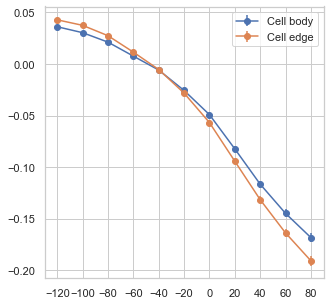

In [64]:
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[5,5])
peak_body_mean = np.nanmean(df['dFF_peak_body'].tolist(), axis=0)
peak_body_sem = np.nanstd(df['dFF_peak_body'].tolist(), axis=0)/(len(df))
peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

# steady_edge_mean = np.nanmean(df['dFF_steady_edge'].tolist(), axis=0)
# steady_edge_sem = np.nanstd(df['dFF_steady_edge'].tolist(), axis=0)/(len(df))
# peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
# peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

x = np.linspace(-120,80,11)
ax = plt.subplot(111)

ax.errorbar(x, peak_body_mean, yerr = peak_body_sem, fmt = 'o-',label='Cell body')
ax.errorbar(x, peak_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell edge')

# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell body')
# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell edge')

ax.legend()
ax.set_xticks(x)
# fig.savefig('/Users/zhengj10/Desktop/manual_group_body_vs_edge_peak.png')
plt.show()


## Ben's processed PB data with peak and steady state dFF

In [21]:
imgPath = '/Users/zhengj10/Desktop/Data anlysis collection/PatcherBot/processed_peak_0324'
rawPath = '/Users/zhengj10/Desktop/Data anlysis collection/PatcherBot/raw'
os.path.exists(imgPath)

True

In [22]:
datePath = pb.getPathInfo(imgPath)
datePath

['2020.02.24_000']

In [1]:
columns = ['Date','Plate','Cell','dFF_p','dFF_s']
df = pd.DataFrame(columns = columns)
df


NameError: name 'pd' is not defined

In [24]:
data_all={}
for param in(df.columns):
    data_all[param] = []
for date in datePath:
    platePath = pb.getPathInfo(os.path.join(rawPath,date))
    for plate in platePath:
        cellPath = pb.getPathInfo(os.path.join(imgPath, date, plate))
        for cell in(cellPath):
            print(cell)
            matFiles = glob(os.path.join(imgPath, date, plate, cell) + '/*.mat')
            if len(matFiles) < 9:
                print('bad trial: ' + '/' + date + '/' + plate + '/' + cell)
                continue
            dFF_p = []
            dFF_s = []
            for trial in range(9):
                matFile = os.path.join(imgPath,date,plate,cell) + '/' + str(trial).zfill(3) + '.mat'
                f = h5py.File(matFile,'r')
                d = f['params']['fit_pix_alpha_single']
                st = d[0]
                obj = f[st]
                dff_p = obj['bkg_norm_ave_dFoF0_transient'][()][0]
                dff_s = obj['bkg_norm_ave_on_dFoF0_plateau'][()][0]
                dFF_p.append(dff_p)
                dFF_s.append(dff_s)
            data_all['Date'].append(date)
            data_all['Plate'].append('plate_000')
            data_all['Cell'].append(cell)
            data_all['dFF_p'].append(dFF_p)
            data_all['dFF_s'].append(dFF_s)
            
               
print('Done!')

patch_attempt_0001_000
patch_attempt_0004_000
patch_attempt_0008_000
patch_attempt_0010_000
patch_attempt_0012_000
patch_attempt_0013_000
Done!


In [25]:
df_new = pd.DataFrame(data_all, columns = list(df))
df = df_new


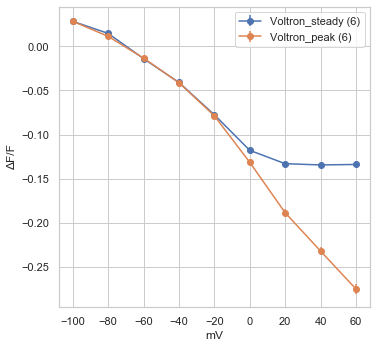

In [26]:
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[5.4,5])
dFF_p_mean = np.nanmean(df['dFF_p'].tolist(), axis=0)
dFF_p_sem = np.nanstd(df['dFF_p'].tolist(), axis=0)/(len(df))
dFF_s_mean = np.nanmean(df['dFF_s'].tolist(), axis=0)
dFF_s_sem = np.nanstd(df['dFF_s'].tolist(), axis=0)/(len(df))

# steady_edge_mean = np.nanmean(df['dFF_steady_edge'].tolist(), axis=0)
# steady_edge_sem = np.nanstd(df['dFF_steady_edge'].tolist(), axis=0)/(len(df))
# peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
# peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

x = np.linspace(-100,60,9)
ax = plt.subplot(111)

ax.errorbar(x, dFF_s_mean, yerr = dFF_s_sem, fmt = 'o-',label='Voltron_steady (6)')
ax.errorbar(x, dFF_p_mean, yerr = dFF_p_sem, fmt = 'o-',label='Voltron_peak (6)')


# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell body')
# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell edge')

ax.legend()
ax.set_xticks(x)
ax.set_xlabel('mV',size=12)
ax.set_ylabel('\u0394F/F',size=12)

plt.tight_layout()
fig.savefig('/Users/zhengj10/Desktop/pb_group_peak_vs_steady_Ben_code.png',dpi=1200)
plt.show()


## Ben's processed manual data with peak and steady state dFF

In [27]:
imgPath = '/Users/zhengj10/Desktop/Data anlysis collection/manual'


In [28]:
# datePath = pb.getPathInfo(imgPath)
datePath = ['190422_0324','190423_0324']

In [29]:
columns = ['Date','Plate','Cell','dFF_p','dFF_s']
df = pd.DataFrame(columns = columns)
df

,Date,Plate,Cell,dFF_p,dFF_s


In [30]:
data_all={}
for param in(df.columns):
    data_all[param] = []
for date in datePath:
    platePath = pb.getPathInfo(os.path.join(imgPath,date))
    for plate in platePath:
        cellPath = pb.getPathInfo(os.path.join(imgPath, date, plate))
        for cell in(cellPath):
            print(cell)
            matFiles = glob(os.path.join(imgPath, date, plate, cell) + '/*.mat')
            dFF_p = []
            dFF_s = []
            matFile = os.path.join(imgPath,date,plate,cell,'trial_0001.mat')
            f = h5py.File(matFile,'r')
            d = f['params']['fit_pix_alpha_single']
            for trial in range(10):
                st = d[trial]
                obj = f[st]
                dff_p = obj['bkg_norm_ave_dFoF0_transient'][()][0]
                dff_s = obj['bkg_norm_ave_on_dFoF0_plateau'][()][0]
                dFF_p.append(dff_p)
                dFF_s.append(dff_s)
            data_all['Date'].append(date)
            data_all['Plate'].append('plate_000')
            data_all['Cell'].append(cell)
            data_all['dFF_p'].append(dFF_p)
            data_all['dFF_s'].append(dFF_s)
            
               
print('Done!')

cell_1
cell_2
cell_3
cell_4
cell_1
cell_2
cell_3
Done!


In [31]:
df_new = pd.DataFrame(data_all, columns = list(df))
df = df_new


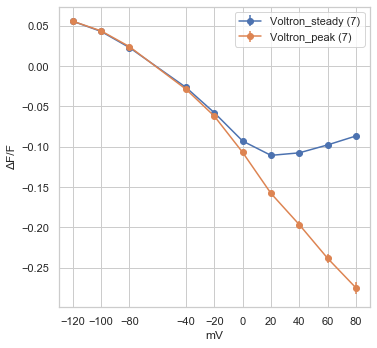

In [32]:
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[5.4,5])
dFF_p_mean = np.nanmean(df['dFF_p'].tolist(), axis=0)
dFF_p_sem = np.nanstd(df['dFF_p'].tolist(), axis=0)/(len(df))
dFF_s_mean = np.nanmean(df['dFF_s'].tolist(), axis=0)
dFF_s_sem = np.nanstd(df['dFF_s'].tolist(), axis=0)/(len(df))

# steady_edge_mean = np.nanmean(df['dFF_steady_edge'].tolist(), axis=0)
# steady_edge_sem = np.nanstd(df['dFF_steady_edge'].tolist(), axis=0)/(len(df))
# peak_edge_mean = np.nanmean(df['dFF_peak_edge'].tolist(), axis=0)
# peak_edge_sem = np.nanstd(df['dFF_peak_edge'].tolist(), axis=0)/(len(df))

x = [-120., -100.,  -80.,  -40.,  -20.,    0.,   20.,   40., 60.,   80.]
ax = plt.subplot(111)

ax.errorbar(x, dFF_s_mean, yerr = dFF_s_sem, fmt = 'o-',label='Voltron_steady (7)')
ax.errorbar(x, dFF_p_mean, yerr = dFF_p_sem, fmt = 'o-',label='Voltron_peak (7)')


# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell body')
# ax.errorbar(x, steady_edge_mean, yerr = peak_edge_sem, fmt = 'o-',label='Cell edge')

ax.legend()
ax.set_xticks(x)
ax.set_xlabel('mV',size=12)
ax.set_ylabel('\u0394F/F',size=12)
plt.tight_layout()
# fig.savefig('/Users/zhengj10/Desktop/manual_group_peak_vs_steady.png',dpi=1200)
plt.show()


#### Pixel value based segmentation

In [ ]:
# sns.reset_orig()
i = 1
dff_list = []
fig = plt.figure(figsize=[10,5])
for trial in range(len(imgFiles)):
    nd2 = nd2reader.Nd2(imgFiles[trial])
    image = np.array(nd2[:])
    ref = np.mean(image[10:60,:,:],axis=0)
#     print(ref.shape)
    fb = np.min(ref)
    
    crop = ref
    max_val = np.max(crop)
    act_pix = crop > (fb + (max_val-fb)*0.3)
    f0 = np.sum(act_pix * crop) / np.sum(act_pix)
    dff = []

    for frame in range(image.shape[0]):
        dff_single = ((np.sum(image[frame, :,:]*act_pix)/np.sum(act_pix)) - f0)/(f0-fb)
        dff.append(dff_single)
    dff = np.mean(dff[500:505])
    dff_list.append(dff)
    if trial==0:
        ax = plt.subplot(1,1,trial+1)
        ax.imshow(act_pix * crop)
    i+=1
# fig.savefig('Y:\\Savepath\\Ahmed-cell_6-ROI.png',dpi=1200)
plt.show()


In [ ]:
# sns.set()
# sns.set_style(style='whitegrid')

# x = np.array([50,30,10,-10,-30,-50,-90,-110])
# ax = plt.subplot(111)
# ax.errorbar(x, dff_list, yerr = 0, fmt = 'o-')

# ax.set_xticks(x)
# ax.set_xlim([58,-118])
# # plt.savefig('Y:\\Savepath\\Ahmed-cell_6.png',dpi=1200)
# plt.show()


In [ ]:
imgFiles = glob(imgPath + '\\*.h5')
imgFiles = sorted(imgFiles)
plt.figure(figsize=[15,15])
for trial in range(len(imgFiles)):

    data = h5py.File(imgFiles[trial])
    print(imgFiles[trial])
    trace = data['sweep_'+str(trial+1).zfill(4)]['analogScans'][()]
    ax = plt.subplot(4,2,trial+1)
#     ax.plot(trace[1])
    print(trace[1][50000]-trace[1][10000])

In [ ]:
# imsave('C:\\Users\\zhengj10\\Desktop\\cell5_V525_0001.tif',image)

In [ ]:
x = np.linspace(50,-110,9)
x